In [1]:
# ============================================================
# 02_diffusion_hopf_DK68.ipynb  (updated version)
# Uses empirical DK68 SC + stable Hopf implementation
# ============================================================

import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.signal import welch, hilbert


# ------------------------------------------------------------------
# Paths
# ------------------------------------------------------------------
DATA_PROC = (
    "/Users/apple/Documents/Computational Neuroscience Paris Saclay/"
    "Supervised projects/main/code/data/processed"
)

os.makedirs(DATA_PROC, exist_ok=True)

# ------------------------------------------------------------------
# Load empirical DK68 structural connectome
# (saved from 01_structural_connectome_analysis.ipynb)
# ------------------------------------------------------------------
W_dk = np.load(f"{DATA_PROC}/W_syn_DK68.npy")
W_dk.shape



(68, 68)

In [3]:
# ============================================================
# 1. Diffusion model on synthetic DK68
# ============================================================

def simulate_diffusion(W, T=1000, S=10, alpha=0.6, noise_std=0.1, seed=42):

    Y_mean = Y_diff.mean(axis=0)   # shape (N, T)
    """
    Simple linear diffusion model on structural connectivity W.

    x_{t+1} = (I - alpha * L_scaled) x_t + noise

    - W: (N, N) structural connectivity (symmetric, zero diagonal)
    - T: number of time steps
    - S: number of independent simulations (subjects/realizations)
    """
    rng = np.random.default_rng(seed)
    N = W.shape[0]

    # Build Laplacian and scale by its largest eigenvalue
    G = nx.from_numpy_array(W)
    L = nx.laplacian_matrix(G).toarray().astype(float)
    evals = np.linalg.eigvalsh(L)
    lambda_max = np.max(evals)
    L_scaled = L / lambda_max

    A = np.eye(N) - alpha * L_scaled  # stable diffusion operator

    Y_all = np.zeros((S, N, T))

    for s in range(S):
        x = rng.normal(scale=1.0, size=N)
        for t in range(T):
            noise = rng.normal(scale=noise_std, size=N)
            x = A @ x + noise
            Y_all[s, :, t] = x

    return Y_all  # shape (S, N, T)


# run diffusion on synthetic DK68
Y_diff = simulate_diffusion(W_dk, T=1000, S=10, alpha=0.6, noise_std=0.1, seed=42)
Y_diff.shape


NameError: name 'Y_diff' is not defined

In [4]:
# (Optional) quick sanity plots for diffusion

S, N, T = Y_diff.shape

plt.figure(figsize=(10, 4))
plt.plot(Y_diff[0, 0:5, :300].T)
plt.title("Diffusion: first 5 regions, first 300 time points (subject 0)")
plt.xlabel("Time")
plt.ylabel("Activity")
plt.tight_layout()
plt.show()

# Functional connectivity of subject 0
fc0 = np.corrcoef(Y_diff[0])
plt.figure(figsize=(4, 4))
plt.imshow(fc0, aspect="auto", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Diffusion FC (subject 0)")
plt.colorbar()
plt.tight_layout()
plt.show()


NameError: name 'Y_diff' is not defined

In [5]:
# ============================================================
# 2. Hopf model on synthetic DK68
# ============================================================

def generate_hopf_data_from_W(
    W,
    T=20000,
    dt_hopf=0.02,
    alpha=0.3,
    omega0=2 * np.pi * 0.05,
    coupling_strength=0.2,
    noise_std=0.02,
    seed=42,
):
    rng = np.random.default_rng(seed)
    N = W.shape[0]

    # Normalize W
    W_norm = W / np.max(np.abs(W))
    np.fill_diagonal(W_norm, 0.0)
    degree = np.sum(W_norm, axis=1)

    # Initial state
    z = 0.1 * (rng.standard_normal(N) + 1j * rng.standard_normal(N))
    Y = np.zeros((N, T))

    # Euler–Maruyama
    for t in range(T):
        coupling = coupling_strength * (W_norm @ z - degree * z)
        dz = (alpha + 1j * omega0 - np.abs(z) ** 2) * z + coupling
        dz += noise_std * rng.standard_normal(N)
        z = z + dt_hopf * dz
        Y[:, t] = z.real

    return Y


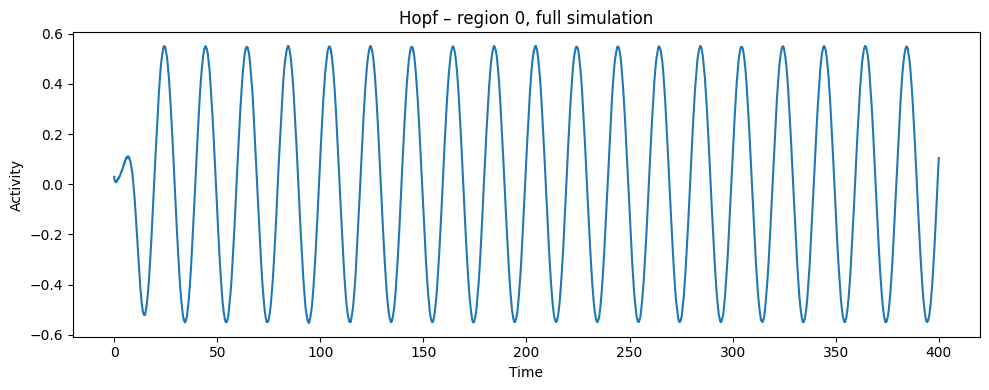

In [6]:
# quick sanity plots for Hopf

dt_hopf = 0.02
Y_hopf = generate_hopf_data_from_W(W_dk)

T  = Y_hopf.shape[1]
t  = np.arange(T) * dt_hopf

plt.figure(figsize=(10, 4))
plt.plot(t, Y_hopf[0, :])   # single region, full trace
plt.xlabel("Time")
plt.ylabel("Activity")
plt.title("Hopf – region 0, full simulation")
plt.tight_layout()
plt.show()


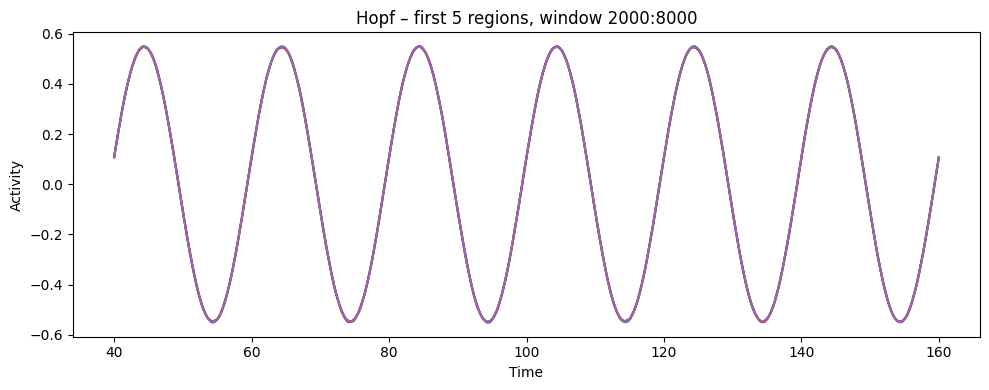

In [7]:
idx0, idx1 = 2000, 8000   # indices
plt.figure(figsize=(10, 4))
plt.plot(t[idx0:idx1], Y_hopf[0:5, idx0:idx1].T)
plt.xlabel("Time")
plt.ylabel("Activity")
plt.title("Hopf – first 5 regions, window 2000:8000")
plt.tight_layout()
plt.show()


In [25]:
# ============================================================
# 4. Save main DK68 time series for downstream DMD / SINDy
# ============================================================

np.save(f"{DATA_PROC}/Y_diff_DK68.npy",  Y_diff)
np.save(f"{DATA_PROC}/Y_hopf_DK68.npy",  Y_hopf)


try:
    np.save(f"{DATA_PROC}/Y_diff_DK68_varA.npy", Y_diff_A)
    np.save(f"{DATA_PROC}/Y_diff_DK68_varB.npy", Y_diff_B)
    np.save(f"{DATA_PROC}/Y_hopf_DK68_varA.npy", Y_hopf_A)
    np.save(f"{DATA_PROC}/Y_hopf_DK68_varB.npy", Y_hopf_B)
except NameError:
    # variants weren't simulated, that's fine
    pass



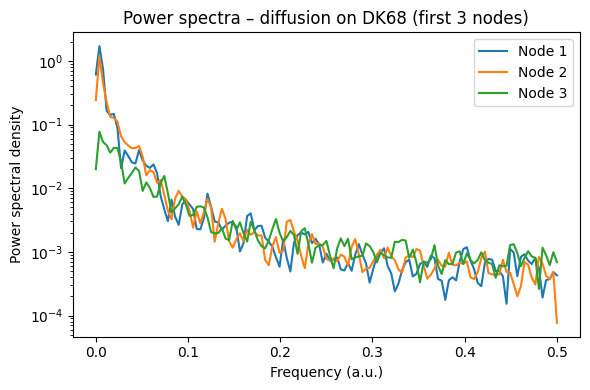

In [27]:
# make sure Y_mean exists
Y_mean = Y_diff.mean(axis=0)   # or Y_diff[0]

fs = 1.0  # arbitrary units
plt.figure(figsize=(6,4))
for i in range(3):
    f, Pxx = welch(Y_mean[i, :], fs=fs, nperseg=256)
    plt.semilogy(f, Pxx, label=f'Node {i+1}')
plt.xlabel("Frequency (a.u.)")
plt.ylabel("Power spectral density")
plt.title("Power spectra – diffusion on DK68 (first 3 nodes)")
plt.legend()
plt.tight_layout()
plt.show()


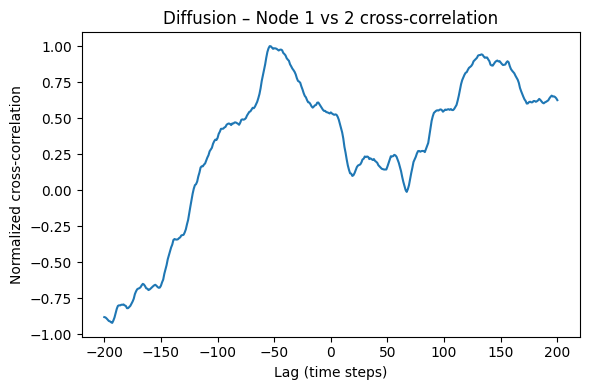

In [28]:
x = Y_mean[0, :] - Y_mean[0, :].mean()
y = Y_mean[1, :] - Y_mean[1, :].mean()

max_lag = 200
lags = np.arange(-max_lag, max_lag+1)
xcorr = np.array([
    np.correlate(x[max(0, lag):len(x)+min(0, lag)],
                 y[max(0, -lag):len(y)-max(0, lag)])[0]
    for lag in lags
])
xcorr /= np.max(np.abs(xcorr))

plt.figure(figsize=(6,4))
plt.plot(lags, xcorr)
plt.xlabel("Lag (time steps)")
plt.ylabel("Normalized cross-correlation")
plt.title("Diffusion – Node 1 vs 2 cross-correlation")
plt.tight_layout()
plt.show()


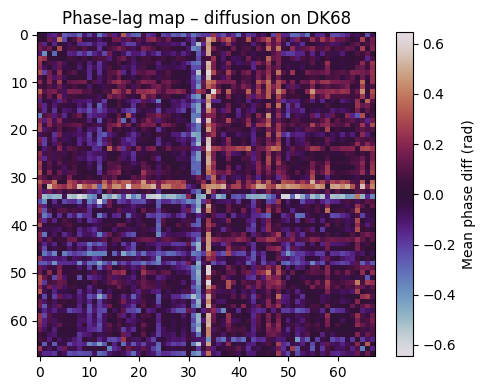

In [29]:
analytic = hilbert(Y_mean, axis=1)   # (N, T)
phase = np.angle(analytic)

N = phase.shape[0]
phase_diff = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        dphi = phase[i, :] - phase[j, :]
        dphi = np.angle(np.exp(1j * dphi))  # wrap
        phase_diff[i, j] = np.mean(dphi)

plt.figure(figsize=(5,4))
plt.imshow(phase_diff, cmap='twilight', aspect='auto')
plt.colorbar(label='Mean phase diff (rad)')
plt.title("Phase-lag map – diffusion on DK68")
plt.tight_layout()
plt.show()


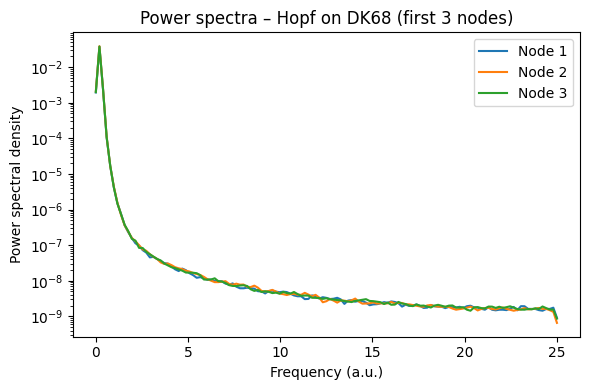

In [30]:
Y_mean = Y_diff.mean(axis=0)   # shape (N, T)

fs = 1.0 / dt_hopf
plt.figure(figsize=(6,4))
for i in range(3):
    f, Pxx = welch(Y_hopf[i, :], fs=fs, nperseg=256)
    plt.semilogy(f, Pxx, label=f'Node {i+1}')
plt.xlabel("Frequency (a.u.)")
plt.ylabel("Power spectral density")
plt.title("Power spectra – Hopf on DK68 (first 3 nodes)")
plt.legend()
plt.tight_layout()
plt.show()



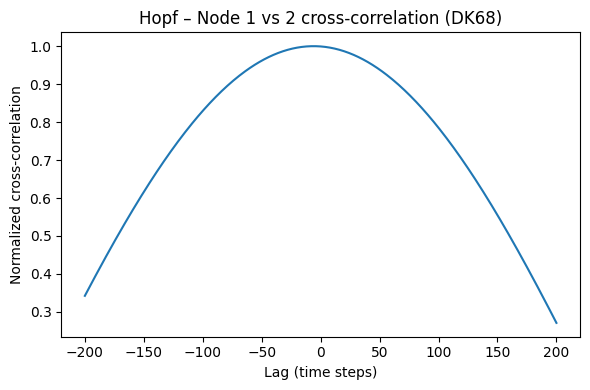

In [31]:
x = Y_hopf[0, :] - Y_hopf[0, :].mean()
y = Y_hopf[1, :] - Y_hopf[1, :].mean()

max_lag = 200
lags = np.arange(-max_lag, max_lag+1)
xcorr = np.array([
    np.correlate(x[max(0, lag):len(x)+min(0, lag)],
                 y[max(0, -lag):len(y)-max(0, lag)])[0]
    for lag in lags
])
xcorr /= np.max(np.abs(xcorr))

plt.figure(figsize=(6,4))
plt.plot(lags, xcorr)
plt.xlabel("Lag (time steps)")
plt.ylabel("Normalized cross-correlation")
plt.title("Hopf – Node 1 vs 2 cross-correlation (DK68)")
plt.tight_layout()
plt.show()


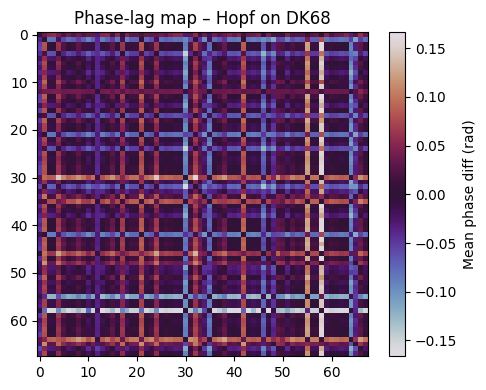

In [32]:
analytic_h = hilbert(Y_hopf, axis=1)
phase_h = np.angle(analytic_h)

N = phase_h.shape[0]
phase_diff_h = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        dphi = phase_h[i, :] - phase_h[j, :]
        dphi = np.angle(np.exp(1j * dphi))
        phase_diff_h[i, j] = np.mean(dphi)

plt.figure(figsize=(5,4))
plt.imshow(phase_diff_h, cmap='twilight', aspect='auto')
plt.colorbar(label='Mean phase diff (rad)')
plt.title("Phase-lag map – Hopf on DK68")
plt.tight_layout()
plt.show()
